In [1]:
'''
CS6140 Final Project - Paddy Disease Detection – Can technology help relieving Food Crisis 2022?
Aug 1, 2022
Wing Man, Kwok

'''
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image        #convert Images to tensor
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
def get_hyperparameters():
    
    batch_size = 128
    learning_rate = 1e-3
    n_epochs = 5
    log_interval = 10
    momentum = 0.5
    
    return batch_size, learning_rate, n_epochs, log_interval, momentum

In [3]:
def check_processor():
    
    if torch.cuda.is_available():
        device = 'cuda'
        print('Using cuda\n')
    else:
        device = 'cpu'
        print('Using cpu\n')
        
    return device

In [4]:
def split_train_test_dataset(training_csv):
       
    train_paths, val_paths, train_labels, val_labels = train_test_split(training_csv["image_id"], training_csv["label"], test_size=0.2, random_state=42)
    
    return train_paths, val_paths, train_labels, val_labels

In [5]:
class PaddyDataset(Dataset):
    
    def __init__(self, dataframe, label2id, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.label2id = label2id
        
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,self.dataframe.iloc[idx, 1],
                                self.dataframe.iloc[idx, 0])
        
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(self.label2id[labelKey]))  
        else:
            label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)
        
        return image,label, img_name

In [6]:
def get_label2id(training_csv):
    
    labelArr = training_csv['label'].unique()
    label2id = {}
    id2label = {}
    index = 0
    
    for  class_name in labelArr:
        label2id[class_name] = str(index)
        id2label[str(index)] = class_name
        index=index +1
  
    return label2id, id2label

In [7]:
def EDA(paddy_dataset, images, labels, training_csv):
    
    print("EDA:", "\n")
          
    print("Training Dataset size:", len(paddy_dataset), "\n")
    print("Label Distribution:\n")
    print(paddy_dataset['label'].value_counts(), "\n")
    
    print("Image size (channel, height, width):", images[0].shape, "\n")
    #print("Visualization of batch #1:")
    #print("-------------------------\n")
    #print("True Labels:\n", labels, len(labels), "\n")

In [8]:
def plot(images, labels, id2label, img_name):
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        plt.title("Ground Truth: {}".format(id2label[str(labels[i])]))
        
        images_rgb = images[i].squeeze()
        images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()
        plt.imshow(cv2.cvtColor(images_rgb, cv2.COLOR_BGR2RGB))
        
        print(img_name[i])
        
    plt.show()

In [9]:
def train_model(n_epochs, model, train_loader, optimizer, log_interval, device):
    
    model.train()
    
    start_time = time.time()
    train_losses = []
    train_counter = []
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target, _) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()                           
        output = model(data)
        loss = criterion(output, target)
        #loss = F.nll_loss(output, target)               
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(n_epochs, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((n_epochs-1)*len(train_loader.dataset)))
            '''
            torch.save(model.state_dict(), './model.pth') 
            torch.save(optimizer.state_dict(), './optimizer.pth')
            '''
    total_time = time.time() - start_time
    print("Total running time:", total_time)

In [10]:
def val_model(model, val_loader, device):
    model.eval()
    
    test_loss = 0
    correct = 0
    model_output = []
    test_losses = []
    files = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():                   #no_grad means no gradient magnitude
        for data, target, file_name in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += criterion(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            model_output.append(output)
            files.append(file_name)
            
    test_loss /= len(val_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100. * correct / len(val_loader.dataset)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

    return model_output[0], files, accuracy.item()

In [11]:
def get_resnet_by_batch_size(model, train_dataset, valid_dataset, batch_size, device):
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers=2)
    
    model.fc =  nn.Sequential(nn.Dropout(0.1),nn.Linear(512, 10))
    model = model.to(device)
    
    return train_dataloader, val_dataloader, model

Training Dataset size: 9886 Validation Dataset Size: 521 

id2label {'0': 'bacterial_leaf_blight', '1': 'bacterial_leaf_streak', '2': 'bacterial_panicle_blight', '3': 'blast', '4': 'brown_spot', '5': 'dead_heart', '6': 'downy_mildew', '7': 'hispa', '8': 'normal', '9': 'tungro'} 

label2id {'bacterial_leaf_blight': '0', 'bacterial_leaf_streak': '1', 'bacterial_panicle_blight': '2', 'blast': '3', 'brown_spot': '4', 'dead_heart': '5', 'downy_mildew': '6', 'hispa': '7', 'normal': '8', 'tungro': '9'} 

Images of first training batch
../input/paddy-doctor/train_images/normal/100664.jpg
../input/paddy-doctor/train_images/normal/109781.jpg


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2314.)
  if sys.path[0] == "":


../input/paddy-doctor/train_images/dead_heart/101724.jpg
../input/paddy-doctor/train_images/hispa/106414.jpg
../input/paddy-doctor/train_images/bacterial_leaf_streak/108603.jpg


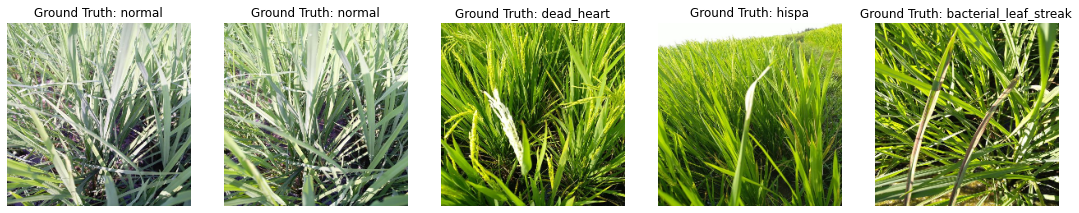

EDA: 

Training Dataset size: 9886 

Label Distribution:

normal                      1683
blast                       1651
hispa                       1498
dead_heart                  1370
tungro                      1036
brown_spot                   913
downy_mildew                 586
bacterial_leaf_blight        463
bacterial_leaf_streak        363
bacterial_panicle_blight     323
Name: label, dtype: int64 

Image size (channel, height, width): torch.Size([3, 224, 224]) 

Using cuda



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Training Resnet34
Train Epoch: 1 [0/9886 (0%)]	Loss: 2.880819
Train Epoch: 1 [1280/9886 (13%)]	Loss: 2.297585
Train Epoch: 1 [2560/9886 (26%)]	Loss: 2.174744
Train Epoch: 1 [3840/9886 (38%)]	Loss: 2.167447
Train Epoch: 1 [5120/9886 (51%)]	Loss: 2.028553
Train Epoch: 1 [6400/9886 (64%)]	Loss: 2.008653
Train Epoch: 1 [7680/9886 (77%)]	Loss: 1.963067
Train Epoch: 1 [8960/9886 (90%)]	Loss: 2.073795
Total running time: 136.84332251548767

Test set: Avg. loss: 0.0186, Accuracy: 196/521 (38%)

Training Resnet34
Train Epoch: 2 [0/9886 (0%)]	Loss: 1.914975
Train Epoch: 2 [1280/9886 (13%)]	Loss: 1.844753
Train Epoch: 2 [2560/9886 (26%)]	Loss: 1.807642
Train Epoch: 2 [3840/9886 (38%)]	Loss: 1.853411
Train Epoch: 2 [5120/9886 (51%)]	Loss: 1.814762
Train Epoch: 2 [6400/9886 (64%)]	Loss: 1.811773
Train Epoch: 2 [7680/9886 (77%)]	Loss: 1.649709
Train Epoch: 2 [8960/9886 (90%)]	Loss: 1.765423
Total running time: 125.39438772201538

Test set: Avg. loss: 0.0162, Accuracy: 252/521 (48%)

Training Resnet3

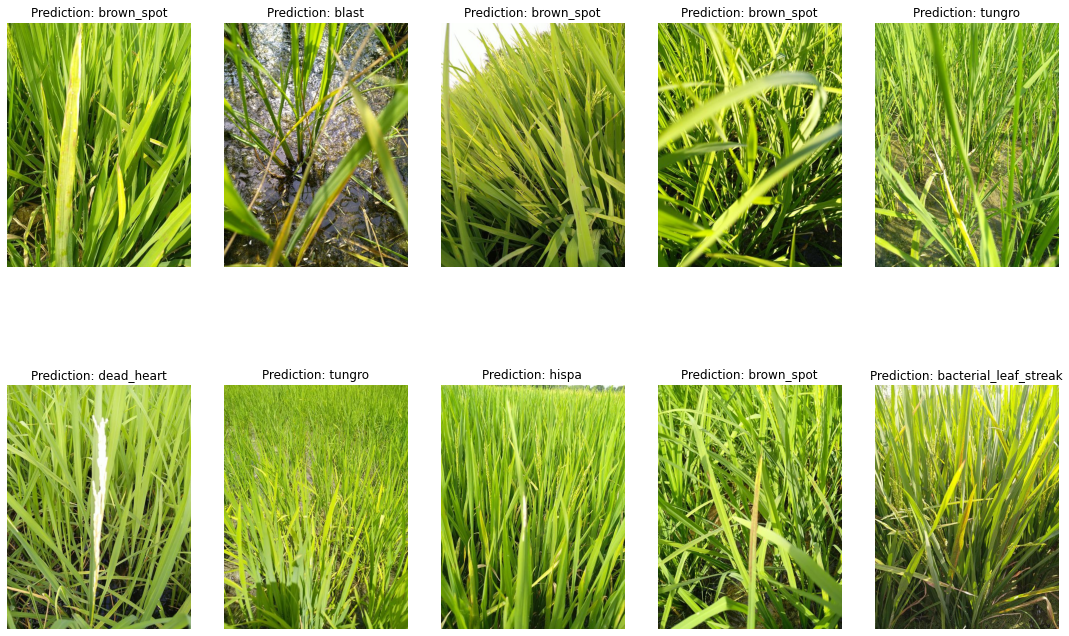

Training Resnet18
Train Epoch: 1 [0/9886 (0%)]	Loss: 2.558009
Train Epoch: 1 [1280/9886 (13%)]	Loss: 2.265976
Train Epoch: 1 [2560/9886 (26%)]	Loss: 2.062356
Train Epoch: 1 [3840/9886 (38%)]	Loss: 2.081496
Train Epoch: 1 [5120/9886 (51%)]	Loss: 2.091929
Train Epoch: 1 [6400/9886 (64%)]	Loss: 1.974563
Train Epoch: 1 [7680/9886 (77%)]	Loss: 1.979942
Train Epoch: 1 [8960/9886 (90%)]	Loss: 1.972550
Total running time: 102.507169008255

Test set: Avg. loss: 0.0186, Accuracy: 195/521 (37%)

Training Resnet18
Train Epoch: 2 [0/9886 (0%)]	Loss: 2.058205
Train Epoch: 2 [1280/9886 (13%)]	Loss: 1.913232
Train Epoch: 2 [2560/9886 (26%)]	Loss: 1.892339
Train Epoch: 2 [3840/9886 (38%)]	Loss: 1.785203
Train Epoch: 2 [5120/9886 (51%)]	Loss: 1.794884
Train Epoch: 2 [6400/9886 (64%)]	Loss: 1.700759
Train Epoch: 2 [7680/9886 (77%)]	Loss: 1.777897
Train Epoch: 2 [8960/9886 (90%)]	Loss: 1.667128
Total running time: 102.38805222511292

Test set: Avg. loss: 0.0169, Accuracy: 235/521 (45%)

Training Resnet18


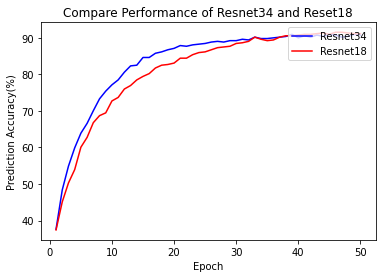

Training Resnet34, batch size 256
Train Epoch: 1 [0/9886 (0%)]	Loss: 2.437294
Train Epoch: 1 [2560/9886 (26%)]	Loss: 2.311802
Train Epoch: 1 [5120/9886 (51%)]	Loss: 2.154168
Train Epoch: 1 [7680/9886 (77%)]	Loss: 2.140375
Total running time: 126.66649866104126

Test set: Avg. loss: 0.0121, Accuracy: 137/521 (26%)

Training Resnet34, batch size 256
Train Epoch: 2 [0/9886 (0%)]	Loss: 2.015879
Train Epoch: 2 [2560/9886 (26%)]	Loss: 1.993949
Train Epoch: 2 [5120/9886 (51%)]	Loss: 1.960216
Train Epoch: 2 [7680/9886 (77%)]	Loss: 1.899941
Total running time: 127.18211579322815

Test set: Avg. loss: 0.0111, Accuracy: 196/521 (38%)

Training Resnet34, batch size 256
Train Epoch: 3 [0/9886 (0%)]	Loss: 1.873403
Train Epoch: 3 [2560/9886 (26%)]	Loss: 1.847334
Train Epoch: 3 [5120/9886 (51%)]	Loss: 1.846621
Train Epoch: 3 [7680/9886 (77%)]	Loss: 1.727270
Total running time: 127.02952027320862

Test set: Avg. loss: 0.0103, Accuracy: 221/521 (42%)

Training Resnet34, batch size 256
Train Epoch: 4 [0/

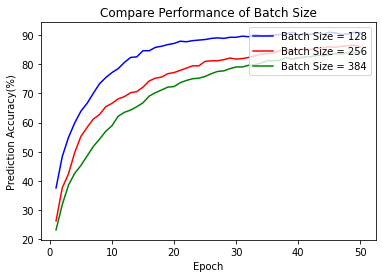

Total running time: 25462.738425970078


In [12]:
def main(argv):

    torch.cuda.empty_cache()
    
    # -------- Prepare dataset
    start_time = time.time()
    
    torch.manual_seed(42)  
    torch.backends.cudnn.enabled = False
    
    batch_size, learning_rate, n_epochs, log_interval, momentum  = get_hyperparameters()

    training_csv = pd.read_csv("../input/paddy-doctor/train.csv")
    train, valid = train_test_split(training_csv, test_size=0.05,random_state=0)
    print("Training Dataset size:", len(train), "Validation Dataset Size:", len(valid), "\n")
    
    label2id, id2label = get_label2id(training_csv)
    print("id2label", id2label, "\n")
    print("label2id", label2id, "\n")

    transform_dataset = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
    
    train_dataset = PaddyDataset(train, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)
    valid_dataset = PaddyDataset(valid, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers=2)
    
    images, labels, img_name = next(iter(train_dataloader))
    print("Images of first training batch")
    plot(images, labels.tolist(), id2label, img_name)
    
    EDA(train, images, labels, training_csv)

    device = check_processor()
    
    # --------- Define resnet34 model
    resnet34 = models.resnet34(pretrained=True)
    resnet34.fc =  nn.Sequential(nn.Dropout(0.1),nn.Linear(512, 10))
    resnet34 = resnet34.to(device)
    
    optimizer_resnet34 = optim.SGD(resnet34.parameters(), lr=learning_rate, momentum=momentum)
    
    # --------- Define resnet18 model
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc =  nn.Sequential(nn.Dropout(0.1),nn.Linear(512, 10))
    resnet18 = resnet18.to(device)
    
    optimizer_resnet18 = optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=momentum)
    
    # ---------- load previous training weights
    
    '''
    network_state_dict = torch.load('../input/paddy-disease-detection/model.pth', map_location = device)
    resnet34.load_state_dict(network_state_dict)
    
    optimizer_state_dict = torch.load('../input/paddy-disease-detection/optimizer.pth', map_location = device)
    optimizer.load_state_dict(optimizer_state_dict)
    '''
    
    # ------- Train Resnet34 as baseline for comparison
    
    n_epochs = 50
    
    accuracy_resnet34 = []
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34")
        train_model(epoch, resnet34, train_dataloader, optimizer_resnet34, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34, val_dataloader, device)
        accuracy_resnet34.append(accuracy)
               
    print("accuracy_resnet34", accuracy_resnet34)
        
    # ------- Visualize reset34 baseline prediction
    test_samples = enumerate(val_dataloader)
    batch_idx, (test_images, test_targets, _) = next(test_samples)
    print("test_targets")
    print(test_targets)
    print("test_images shape", test_images.shape)
    
    pred, filenames, accuracy = val_model(resnet34, val_dataloader, device)
    
    transform = T.ToPILImage()
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(10):
        plt.subplot(3, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        
        prediction = np.argmax(pred[i].cpu()).item()
        plt.title("Prediction: {}".format(id2label[str(prediction)]))
        
        plt.imshow(cv2.cvtColor(cv2.imread(filenames[0][i]), cv2.COLOR_BGR2RGB))
      
        print(filenames[0][i])
        
    plt.show()
    
    # ----- Train Resnet18 and compare Resnet34 and Reset18
    
    accuracy_resnet18 = []
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet18")
        train_model(epoch, resnet18, train_dataloader, optimizer_resnet18, log_interval, device)
        pred, filenames, accuracy = val_model(resnet18, val_dataloader, device)
        accuracy_resnet18.append(accuracy)
 
    print("accuracy_resnet18", accuracy_resnet18)

    epoch = np.linspace(1,len(accuracy_resnet34),len(accuracy_resnet34));
    
    plt.title("Compare Performance of Resnet34 and Reset18"); plt.xlabel("Epoch"); plt.ylabel("Prediction Accuracy(%)")
    plt.plot(epoch, accuracy_resnet34, color = 'blue' )
    plt.plot(epoch, accuracy_resnet18, color = 'red' )
    plt.legend(['Resnet34', 'Resnet18'], loc='upper right')
    plt.show()
    
    # ------ Compare Batch Size
    # -------------------------- Get model by batch size 256
    
    batch_size = 256
    accuracy_resnet34_batch_256 = []
    
    resnet34_batch_256 = models.resnet34(pretrained=True)
    
    train_dataloader, val_dataloader, resnet34_batch_256 = get_resnet_by_batch_size(resnet34_batch_256, train_dataset, valid_dataset, batch_size, device)

    optimizer_resnet34_batch_256 = optim.SGD(resnet34_batch_256.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34, batch size", batch_size)
        train_model(epoch, resnet34_batch_256, train_dataloader, optimizer_resnet34_batch_256, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34_batch_256, val_dataloader, device)
        accuracy_resnet34_batch_256.append(accuracy)
               
    print("accuracy_resnet34_batch_256", accuracy_resnet34_batch_256, "\n")
    
     # -------------------------- Get model by batch size 512
        
    batch_size = 384   
    accuracy_resnet34_batch_384 = []
    
    resnet34_batch_384 = models.resnet34(pretrained=True)
    
    train_dataloader, val_dataloader, resnet34_batch_384 = get_resnet_by_batch_size(resnet34_batch_384, train_dataset, valid_dataset, batch_size, device)

    optimizer_resnet34_batch_384 = optim.SGD(resnet34_batch_384.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34, batch size", batch_size)
        train_model(epoch, resnet34_batch_384, train_dataloader, optimizer_resnet34_batch_384, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34_batch_384, val_dataloader, device)
        accuracy_resnet34_batch_384.append(accuracy)
               
    print("accuracy_resnet34_batch_384", accuracy_resnet34_batch_384)
    
    epoch = np.linspace(1,len(accuracy_resnet34_batch_256),len(accuracy_resnet34_batch_256));
    
    plt.title("Compare Performance of Batch Size"); plt.xlabel("Epoch"); plt.ylabel("Prediction Accuracy(%)")
    plt.plot(epoch, accuracy_resnet34, color = 'blue' )
    plt.plot(epoch, accuracy_resnet34_batch_256, color = 'red' )
    plt.plot(epoch, accuracy_resnet34_batch_384, color = 'green' )
    plt.legend(['Batch Size = 128', 'Batch Size = 256', 'Batch Size = 384'], loc='upper right')
    plt.show()
    
    # ----- Compute total time
    total_time = time.time() - start_time
    print("Total running time:", total_time)
                  
    return

if __name__ == "__main__":
    main(sys.argv)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session